In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import filter_data, get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks, resection_grid_results

plt.style.use('/om2/user/eisenaj/code/UniversalUnconsciousness/sci_style.mplstyle')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
with initialize(version_base="1.3", config_path="../../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class)) if f.endswith('.mat')]
# session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]

# session_list = [session_list[1]]
# session_list = [session_list[2]]
# session_list = ['SPOCK_Ketamine_20210712', 'PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220203']
# session_list = ['PEDRI_Ketamine_20220113']
# session_list = [session_list[0]]

In [5]:
session_list

['MrJones-Anesthesia-20160125-01',
 'MrJones-Anesthesia-20160210-01',
 'Mary-Anesthesia-20160818-02',
 'MrJones-Anesthesia-20160121-01',
 'Mary-Anesthesia-20160822-02',
 'Mary-Anesthesia-20160809-01',
 'MrJones-Anesthesia-20160301-01',
 'Mary-Anesthesia-20160908-02',
 'Mary-Anesthesia-20160902-02',
 'Mary-Anesthesia-20160912-02',
 'MrJones-Anesthesia-20160105-01',
 'MrJones-Anesthesia-20160201-01',
 'MrJones-Anesthesia-20160113-01',
 'Mary-Anesthesia-20160916-02',
 'Mary-Anesthesia-20160826-02',
 'MrJones-Anesthesia-20160206-01',
 'MrJones-Anesthesia-20160107-01',
 'Mary-Anesthesia-20160914-02',
 'MrJones-Anesthesia-20160123-01',
 'Mary-Anesthesia-20160831-02',
 'MrJones-Anesthesia-20160109-01']

In [6]:
# areas = ['vlPFC', 'dlPFC', '-R', '-L']
areas = ['all', 'vlPFC', 'FEF', '7b', 'CPB']

## PCA

In [7]:
if cfg.params.pca:
    pca_chosen = {}
    for session in session_list:
        section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
        
        print("-"*20)
        print(f"SESSION = {session}")
        print("-"*20)
    
        normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
        filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    
        pca_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, "PCA_info", session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}")
        os.makedirs(pca_dir, exist_ok=True)
    
        pca_chosen[session] = {}
        for area in areas:
    
            # Get the relevant indices for each area
            os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
            variables = ['electrodeInfo']
            session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
            electrode_info = session_vars['electrodeInfo']
    
            if area == 'all':
                dimension_inds = np.arange(len(electrode_info['area']))
            else:
                # dimension_inds = np.where(electrode_info['area'] == area)[0]
                dimension_inds = np.where([area in area_entry for area_entry in electrode_info['area']])[0]
    
            # Get PCA explained variance ratios
            area_pca_file = os.path.join(pca_dir, area)
            if os.path.exists(area_pca_file):
                print(f"Found PCA info for {session}: {area}")
                pca_explained_variance_ratios = pd.read_pickle(area_pca_file)
            else:
                print(f"Computing PCA info for {session}: {area}")
                grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)
    
                directory = pd.read_pickle(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, f"{session}_lfp_chunked_20s", "directory"))
            
                pca_explained_variance_ratios = {}
                for t in tqdm(grid_search_window_start_ts, desc=f'Doing PCA for {session}: {area}'):
                    lfp = load_window_from_chunks(t, t + cfg.params.window, directory=directory, dimension_inds=dimension_inds)
                    lfp = lfp[::cfg.params.subsample]
                    # filter
                    pca = PCA(n_components=lfp.shape[1]).fit(lfp)
                    pca_explained_variance_ratios[t] = pca.explained_variance_ratio_
    
                pd.to_pickle(pca_explained_variance_ratios, area_pca_file)
    
            # pick the max number of PCs across windows greater than the threshold
            pca_chosen[session][area] = np.max([np.argmax(np.cumsum(evr) >= cfg.params.pca_thresh) for evr in pca_explained_variance_ratios.values()])
else:
    pca_chosen = None

# Collect Indices to Run

In [8]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)
    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'

    grid_search_run_list = get_grid_search_run_list(session, os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class), cfg.params.all_data_dir, cfg.params.window, cfg.grid_sets[cfg.params.grid_set], cfg.params.grid_set, grid_search_window_start_ts, cfg.params.T_pred, group_ranks=cfg.params.group_ranks, verbose=True, random_state=cfg.params.random_state)

    for area in areas:
        
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, 'grid_search_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)

        
        if not cfg.params.group_ranks:
            # filter runs for those with valid rank
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                if cfg.params.pca:
                    n_dims = pca_chosen[session][area]
                else:
                    n_dims = len(run_info['dimension_inds'])
                    if run_info['n_delays']*n_dims >= run_info['rank']:
                        run_info['run_index'] = run_index
                        filtered_run_list.append(run_info)
        else: # runs don't need to be filtered
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                run_info['run_index'] = run_index
                filtered_run_list.append(run_info)
        
        indices_to_run = []
        for run_info in filtered_run_list:
            filename = f"run_index-{run_info['run_index']}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_info['run_index'])
    
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(filtered_run_list):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = MrJones-Anesthesia-20160125-01
--------------------
*COMPLETE*: All results completed for MrJones-Anesthesia-20160125-01 - all!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160125-01 - vlPFC!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160125-01 - FEF!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160125-01 - 7b!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160125-01 - CPB!!
--------------------
SESSION = MrJones-Anesthesia-20160210-01
--------------------
*COMPLETE*: All results completed for MrJones-Anesthesia-20160210-01 - all!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160210-01 - vlPFC!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160210-01 - FEF!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160210-01 - 7b!!
*COMPLETE*: All results completed for MrJones-Anesthesia-20160210-01 - CPB!!
--------------------
SESSION = Mary-Anesthesia-20160818-02
---

# Running

In [9]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [10]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            else:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data:   0%|          | 0/82 [00:00<?, ?it/s]

Running indices for MrJones-Anesthesia-20160125-01 - 7b
running batch #0
[2024-09-19 09:50:36,970][HYDRA] Submitit 'slurm' sweep output dir : multirun/2024-09-19/09-50-17
[2024-09-19 09:50:36,971][HYDRA] 	#0 : ++params.session=MrJones-Anesthesia-20160125-01 ++params.area=7b ++params.run_index=0
[2024-09-19 09:50:36,975][HYDRA] 	#1 : ++params.session=MrJones-Anesthesia-20160125-01 ++params.area=7b ++params.run_index=1
[2024-09-19 09:50:36,978][HYDRA] 	#2 : ++params.session=MrJones-Anesthesia-20160125-01 ++params.area=7b ++params.run_index=2
[2024-09-19 09:50:36,981][HYDRA] 	#3 : ++params.session=MrJones-Anesthesia-20160125-01 ++params.area=7b ++params.run_index=3
[2024-09-19 09:50:36,985][HYDRA] 	#4 : ++params.session=MrJones-Anesthesia-20160125-01 ++params.area=7b ++params.run_index=4
[2024-09-19 09:50:36,989][HYDRA] 	#5 : ++params.session=MrJones-Anesthesia-20160125-01 ++params.area=7b ++params.run_index=5
[2024-09-19 09:50:36,992][HYDRA] 	#6 : ++params.session=MrJones-Anesthesia-2016

# Collect Grid Search Results

In [104]:
cfg.params.stat_to_use = 'aic'

In [105]:
grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen)

In [10]:
# sections_to_use = ['awake oddball', 'unconscious oddball', 'recovery oddball']
grid_search_results = resection_grid_results(cfg, grid_search_results, cfg.params.sections_to_use)

NameError: name 'grid_search_results' is not defined

In [11]:
session = session_list[0]
area = areas[0]

In [12]:
plt.figure(figsize=(26, 5))

n_ranks = np.argmax(np.isnan(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][0, -1]))
results_to_show = deepcopy(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][:, :, :n_ranks])
# results_to_show[results_to_show == 0] = np.nan

im = plt.imshow(results_to_show.mean(axis=0), aspect='auto')
i, j = grid_search_results[session][area]['i'], grid_search_results[session][area]['j']
plt.scatter(j, i, c='r')
n_delays = grid_search_results[session][area]['n_delays']
rank = grid_search_results[session][area]['rank']
plt.text(j, i - 0.5, f"{n_delays} delays, rank {rank}", c='r', ha='center', fontsize=14)
plt.xticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].rank_vals))[:n_ranks], cfg.grid_sets[cfg.params.grid_set].rank_vals[:n_ranks])
plt.yticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].n_delays_vals)), cfg.grid_sets[cfg.params.grid_set].n_delays_vals)
plt.ylabel('# delays')
plt.xlabel('rank')
plt.colorbar(im)
plt.show()

NameError: name 'grid_search_results' is not defined

<Figure size 7800x1500 with 0 Axes>

In [13]:
# base_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/leverOddball/delase_results"
# for session in os.listdir(base_dir):
#     working_dir = base_dir
    
#     while 'STAT_TO_USE' not in os.path.basename(working_dir):
#         working_dir = os.path.join(working_dir, os.listdir(working_dir)[0])

#     os.chdir(working_dir)
#     os.makedirs('SECTIONS_TO_USE_all_sections', exist_ok=True)
#     os.system("mv * SECTIONS_TO_USE_all_sections")

In [14]:
# base_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/DeLASE_results/leverOddball/delase_run_lists"
# os.chdir(base_dir)
# for f in os.listdir(base_dir):
#     os.system(f"mv {f} {f+'__SECTIONS_TO_USE_all_sections'}")
#     # os.system(f"mv {f} {f.split('__')[0]}")

# Get DeLASE Run List

In [15]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    delase_run_list = get_delase_run_list(cfg, session)

    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    sections_to_use_folder = 'SECTIONS_TO_USE_' + '__'.join(['_'.join(section.split(' ')) for section in cfg.params.sections_to_use])

    for area in areas:
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.delase_results_dir, cfg.params.data_class, 'delase_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, f"STAT_TO_USE_{cfg.params.stat_to_use}", sections_to_use_folder, f"STRIDE_{cfg.params.stride}", area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)
        indices_to_run = []
        for run_index in range(len(delase_run_list[area])):
            filename = f"run_index-{run_index}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_index)
        
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(delase_run_list[area]):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = SPOCK_Dexmedetomidine_20211123
--------------------
NOT STARTED: no results completed for SPOCK_Dexmedetomidine_20211123 - all. Adding all indices! (912)
NOT STARTED: no results completed for SPOCK_Dexmedetomidine_20211123 - vlPFC. Adding all indices! (912)


KeyError: 'FEF'

### Run

In [112]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [113]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.n_delays={int(grid_search_results[session][area]['n_delays'])} ++params.rank={int(grid_search_results[session][area]['rank'])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            else:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase.py -m ++params.session={session} ++params.area={area} ++params.n_delays={int(grid_search_results[session][area]['n_delays'])} ++params.rank={int(grid_search_results[session][area]['rank'])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data:   0%|          | 0/54 [00:00<?, ?it/s]

Running indices for MrJones-Anesthesia-20160210-01 - all
running batch #0
[2024-09-18 04:49:32,949][HYDRA] Submitit 'slurm' sweep output dir : multirun/2024-09-18/04-49-06
[2024-09-18 04:49:32,951][HYDRA] 	#0 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.n_delays=5 ++params.rank=1150 ++params.run_index=0
[2024-09-18 04:49:32,955][HYDRA] 	#1 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.n_delays=5 ++params.rank=1150 ++params.run_index=1
[2024-09-18 04:49:32,959][HYDRA] 	#2 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.n_delays=5 ++params.rank=1150 ++params.run_index=2
[2024-09-18 04:49:32,963][HYDRA] 	#3 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.n_delays=5 ++params.rank=1150 ++params.run_index=3
[2024-09-18 04:49:32,966][HYDRA] 	#4 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.n_delays=5 ++params.rank=1150 ++params.run_index=4
[20

# Collect DeLASE Results

In [114]:
delase_results = get_delase_results(cfg, session_list, areas, pca_chosen)

In [115]:
session_rets = {}
for session in tqdm(session_list):
    # print("-"*30)
    # print(f'SESSION = {session}')
    # print("-"*30)
    session_rets[session] = {}
    # ---------------------------------
    # LOAD DATA
    # --------------------------------
    # print("loading data...")
    variables = ['electrodeInfo', 'sessionInfo']
    session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
    electrode_info, session_info = session_vars['electrodeInfo'], session_vars['sessionInfo']

    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

    section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    section_times = {}
    for section, times in section_info:
        section_times[section] = (times[0], times[1])

    sections = list(section_times.keys())

    directory = pd.read_pickle(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, f"{session}_lfp_chunked_20s", "directory"))
    
    session_rets[session]['electrode_info'] = electrode_info
    session_rets[session]['session_info'] = session_info
    session_rets[session]['eyes_open'] = eyes_open
    session_rets[session]['eyes_close'] = eyes_close
    session_rets[session]['section_times'] = section_times
    session_rets[session]['sections'] = sections
    session_rets[session]['directory'] = directory

    session_rets[session]['results_dict'] = delase_results[session]

  0%|          | 0/21 [00:00<?, ?it/s]

------------------------------
SESSION = MrJones-Anesthesia-20160125-01
------------------------------
loading data...
------------------------------
SESSION = MrJones-Anesthesia-20160210-01
------------------------------
loading data...
------------------------------
SESSION = Mary-Anesthesia-20160818-02
------------------------------
loading data...
------------------------------
SESSION = MrJones-Anesthesia-20160121-01
------------------------------
loading data...
------------------------------
SESSION = Mary-Anesthesia-20160822-02
------------------------------
loading data...
------------------------------
SESSION = Mary-Anesthesia-20160809-01
------------------------------
loading data...
------------------------------
SESSION = MrJones-Anesthesia-20160301-01
------------------------------
loading data...
------------------------------
SESSION = Mary-Anesthesia-20160908-02
------------------------------
loading data...
------------------------------
SESSION = Mary-Anesthesia-201

In [116]:
session_infos = {}
section_infos = {}
for session in tqdm(session_list):
    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
    session_info = session_vars['sessionInfo']
    session_infos[session] = session_info

    section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    section_infos[session] = section_info

  0%|          | 0/21 [00:00<?, ?it/s]

In [117]:
leadup_time = 18 # minutes before anesthesia
post_time = 25 # minutes after anesthesia
dt_stab = 0.1
top_percent = 0.1
split_by_monkey = True
stability_all = {}
freqs_all = {}
counts = {}
if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
    monkey_sessions = {monkey: [session for session in session_list if monkey in session] for monkey in monkeys}
    session_dicts = {monkey: {session: session_rets[session] for session in monkey_sessions[monkey]} for monkey in monkeys}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}
else:
    monkeys = ['Combined']
    monkey_sessions = {'Combined': session_list}
    session_dicts = {'Combined': session_rets}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}
    
for monkey in monkeys:
    stability_all[monkey] = {}
    freqs_all[monkey] = {}
    counts[monkey] = {}
    
# areas = ['vlPFC', 'FEF', '7b', 'CPB']
# areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']
areas = ['all']

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].window_start >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].window_end <= session_dict['session_info']['drugEnd'][1] + post_time*60))

iterator = tqdm(total=total_its)

for monkey in monkeys:
    for area in areas:
        # num_params = np.min([len(session_dict['results_dict'][area].stability_params.iloc[0]) for session_dict in session_rets.values()])
        stability_all[monkey][area] = np.zeros((int((leadup_time + 60 + post_time)*60*(1/dt_stab)), num_sessions[monkey]), dtype=np.float32)
        freqs_all[monkey][area] = np.zeros(stability_all[monkey][area].shape, dtype=np.float32)
        counts[monkey][area] = np.zeros(stability_all[monkey][area].shape, dtype=np.int16)
        # raise ValueError
        for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
            filter_inds = np.logical_and(session_dict['results_dict'][area].window_start >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].window_end <= session_dict['session_info']['drugEnd'][1] + post_time*60)
            for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.window_start)/dt_stab)
                end_ind = start_ind + int(np.ceil((row.window_end - row.window_start)/dt_stab))
                if start_ind > len(stability_all[monkey][area]):
                    print(start_ind, len(stability_all[monkey][area]))
                    raise ValueError
                # there are a few points where the time windows overlap but I decided to just
                # overwrite the data. it's only like 7 or 8 points
                stability_all[monkey][area][start_ind:end_ind, session_ind] = row.stability_params[:int(top_percent*len(row.stability_params))].mean()
                freqs_all[monkey][area][start_ind:end_ind, session_ind] = row.stability_freqs[:int(top_percent*len(row.stability_freqs))].mean()
                counts[monkey][area][start_ind:end_ind, session_ind] = 1
                # counts[monkey][area][start_ind:end_ind, session_ind] += 1
                # np.where(counts[monkey][area][time_inds] == 2)
                iterator.update()
iterator.close()

  0%|          | 0/8587 [00:00<?, ?it/s]

In [118]:
area_colors = {
    'vlPFC': 'C0',
    'FEF': 'skyblue',
    '7b': 'slategray',
    'CPB': 'lightsteelblue', 
    'all': 'purple'
}

# area_colors = {
#     'vlPFC': palette2[0], 
#     'FEF': palette2[2],
#     '7b': palette2[3],
#     'CPB': palette2[4]
# }
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

# section_info = [('awake', [-15, 0]), ('induction', [0, 15]), ('unconscious', [15, 60]), ('late recovery', [75, 85]), ('recovery', [60, 85]), ('loading dose', [15, 30]), ('maintenance dose', [45, 60]), ('early recovery', [60, 75])]
section_info = [('awake', [-15, 0]), ('induction', [0, 15]), ('unconscious', [15, 60]), ('late recovery', [68, 75]), ('recovery', [60, 75]), ('loading dose', [15, 30]), ('maintenance dose', [45, 60]), ('early recovery', [60, 68])]

section_colors = {
    'awake': 'limegreen',
    'unconscious': 'plum',
    'recovery': 'orange',
    # 'loading dose': 'mediumorchid',
    # 'loading dose': '#CA68CA',
    # 'loading dose': 'orchid',
    'loading dose': '#D65CD4',
    # 'maintenance dose': 'orchid',
    'maintenance dose': '#E28DE0',
    'early recovery': 'chocolate',
    'late recovery': '#FFBF47',
    'induction': '#61C9A8'
}

In [119]:
eyes_closes = {}
eyes_opens = {}
for monkey in monkeys:
    eyes_closes[monkey] = []
    eyes_opens[monkey] = []
    for session, session_dict in session_rets.items():
        if len(monkey) == 1 or monkey in session:
            
            eyes_closes[monkey].append(session_dict['eyes_close'] - session_dict['session_info']['drugStart'][0])
            eyes_opens[monkey].append(session_dict['eyes_open']  - session_dict['session_info']['drugStart'][0])

4.5200000000000005 2.324500000000001


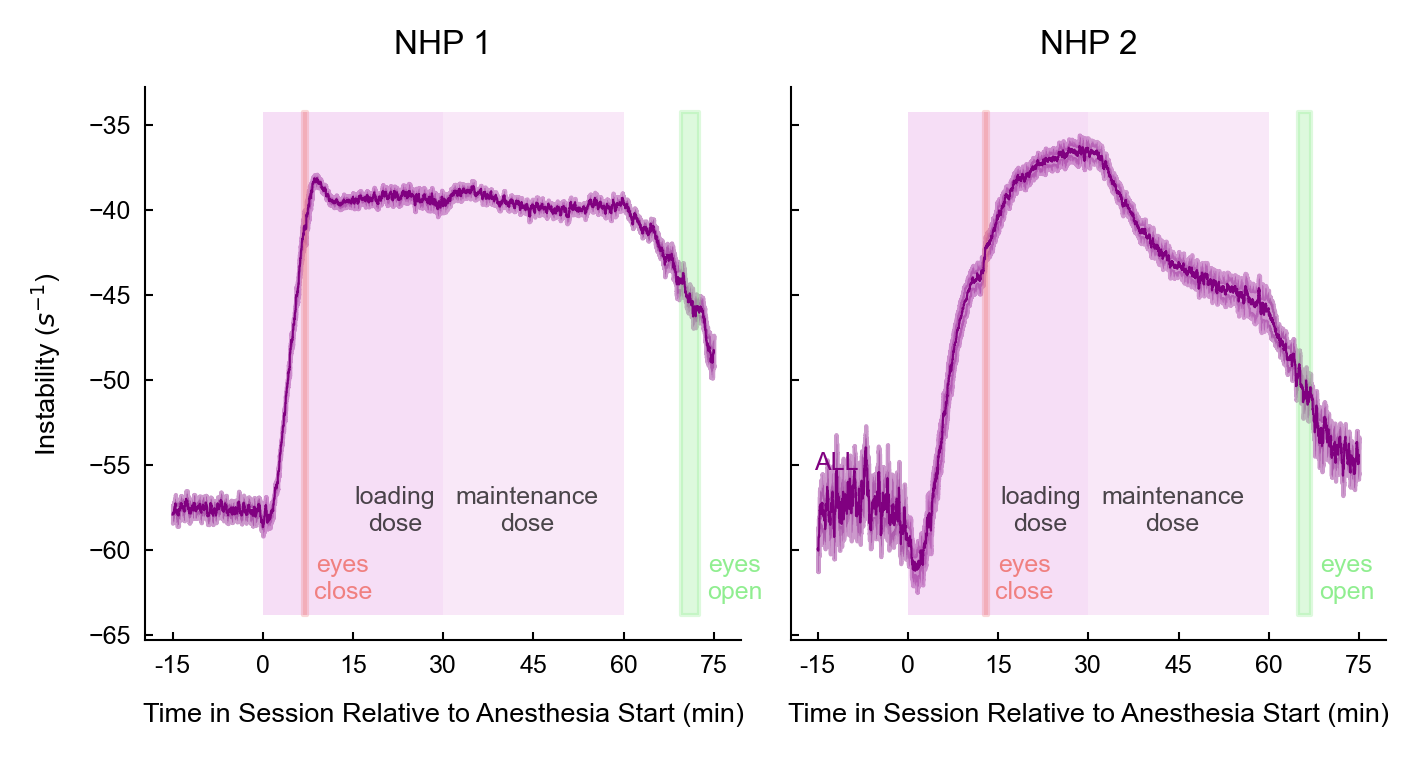

In [120]:
# leadup_time = 18 # minutes before anesthesia
# post_time = 25 # minutes after anesthesia
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 15
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 2, figsize=(4.7, 2.5045), sharey=True)

lns = []

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for area in stability_all[monkey].keys():
        # raise ValueError
        mean_vals = stability_all[monkey][area][time_inds].sum(axis=-1)/counts[monkey][area][time_inds].sum(axis=-1)
        std_dev_vals = np.sqrt(np.square(stability_all[monkey][area][time_inds] - np.expand_dims(mean_vals, -1)).sum(axis=-1)/(counts[monkey][area][time_inds].sum(axis=-1) - 1))
        se_vals = std_dev_vals/np.sqrt(counts[monkey][area][time_inds].sum(axis=-1))
        ax.plot(time_vals[time_inds], mean_vals, label=area_labels[area], color=area_colors[area], rasterized=True)
        # ax.errorbar(time_vals[time_inds], mean_vals, color=area_colors[area], yerr=se_vals, ls='none', alpha=0.4)
        ax.fill_between(time_vals[time_inds], mean_vals - se_vals, mean_vals + se_vals, color=area_colors[area], alpha=0.4, rasterized=True)
        #         lower_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] - se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         upper_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] + se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         ax.fill_between(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], lower_bound, upper_bound, alpha=0.4, color=area_colors[area])
        
        if i == 0:
            ln1 = ax.plot([], label=area_labels[area], color=area_colors[area])
            lns += ln1
            
            if area == 'vlPFC':
                ax.text(60 + (plot_end_time - 60)*0.9, stability_all[monkey][area][time_vals >= 60].mean() - 2, area_labels[area], color=area_colors[area])
            if area == 'CPB':
                ax.text(60 + (plot_end_time - 60)*1.04, stability_all[monkey][area][time_vals >= 60].mean() - 2.5, area_labels[area], color=area_colors[area])
            if area == '7b':
                    ax.text(60 + (plot_end_time - 60)*1.15, -27, area_labels[area], color=area_colors[area])
        if i == 1:
            # if area == '7b':
            #     ax.text(-15, stability_all[monkey][area][time_vals <= 0].mean() + 2.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)

            
            if area == 'FEF':
                ax.text(-15, stability_all[monkey][area][time_vals <= 0].mean() - 4.8, area_labels[area], color=area_colors[area])
            # if area == 'CPB':
            #     ax.text(-15, stability_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
                
            if area == 'all':
                ax.text(-15.6, stability_all[monkey][area][time_vals <= 0].mean() + 2.2, area_labels[area], color=area_colors[area])
ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    # fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
    alpha_val = 0.2
    fill1 = ax.fill_betweenx(ylim, 0, 30, color=section_colors['loading dose'], alpha=alpha_val, label='infusion 1', edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color=section_colors['maintenance dose'], alpha=alpha_val, label='infusion 2', edgecolor='none')
    ax.text(22, ylim[0] + 5, 'loading\ndose', c='k', alpha=0.7, horizontalalignment='center',)
    ax.text(44, ylim[0] + 5, 'maintenance\ndose', c='k', alpha=0.7, horizontalalignment='center',)
    if i == 0:
        lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
        lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
    if i == 0:
        # ax.spines[['right', 'top']].set_visible(False)
        # ax.xaxis.set_ticks_position('bottom')
        # ax.yaxis.set_ticks_position('left')
        # ax.set_ylabel(f'Mean of Top {top_percent*100:.0f}% Instability ' + r'($s^{-1}$)', fontsize=ylabel_fontsize)
        ax.set_ylabel(f'Instability ' + r'($s^{-1}$)')
    else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
        # ax.spines[['right', 'top']].set_visible(False)
        # ax.xaxis.set_ticks_position('bottom')
        # ax.tick_params(axis='y', which='both', left=True, right=False)
        pass
    
    xticks = [-15, 0, 15, 30, 45, 60, 75]
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Time in Session Relative to Anesthesia Start (min)')
    # ax.tick_params(labelsize=tick_fontsize)
    ax.set_title(f'NHP {i + 1}')
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.text((mean_eyes_close + se_eyes_close)/60 + 6, ylim[0] + 1, 'eyes\nclose', color='lightcoral', horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.text((mean_eyes_open + se_eyes_open)/60 + 6, ylim[0] + 1, 'eyes\nopen', color='lightgreen', horizontalalignment='center')
# fig.legend(lns, [ln.get_label() for ln in lns], bbox_to_anchor=(0.9, -0.01), ncol=len(lns), fontsize=legend_fontsize)
plt.tight_layout()
# plt.savefig(os.path.join(img_save_dir, "main", "stability-neural-all.pdf"), bbox_inches='tight', transparent=True)

bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# Calculate width and height of the bounding box in inches
width_inches = (bbox.x1 - bbox.x0)
height_inches = (bbox.y1 - bbox.y0)
print(width_inches, height_inches)

plt.show()

# Investigating Peaks

In [64]:
trial_info = load_session_data(session, cfg.params.all_data_dir, ['trialInfo'], data_class=cfg.params.data_class, verbose=False)[0]['trialInfo']

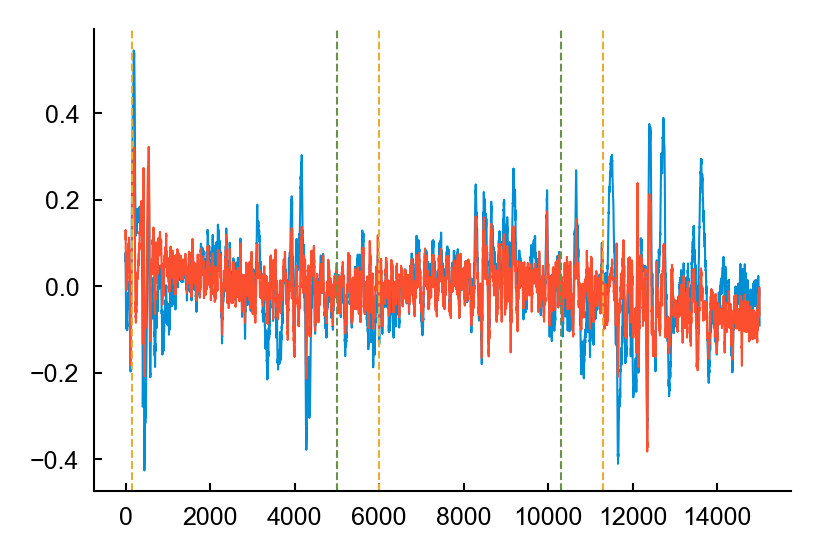

In [74]:
df = session_rets[session]['results_dict'][area]
idx_max_w = df[df.window_start/60 - session_rets[session]['session_info']['drugStart'][0]/60 <= 0].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).idxmax()
lfp_max_w = load_window_from_chunks(df.window_start.iloc[idx_max_w], df.window_end.iloc[idx_max_w], directory=directory)
lfp_max_wf = filter_data(lfp_max_w, cfg.params.low_pass, cfg.params.high_pass, dt=dt)

rel_events = {}
for key in ['cpt_puffOn', 'cpt_toneOn']:
    rel_events[key] = trial_info[key][(trial_info[key] >= df.window_start.loc[idx_max_w]) & (trial_info[key] <= df.window_end.loc[idx_max_w])]

plt.plot(lfp_max_w[:, 0])
plt.plot(lfp_max_wf[:, 0])
for i, key in enumerate(rel_events.keys()):
    for event in rel_events[key]:
        plt.axvline((event - df.window_start.loc[idx_max_w])/dt, c=f'C{i + 2}', linestyle='--')
plt.show()

In [81]:
lfp_max_wf2 = filter_data(lfp_max_w, None, 4, dt=dt)

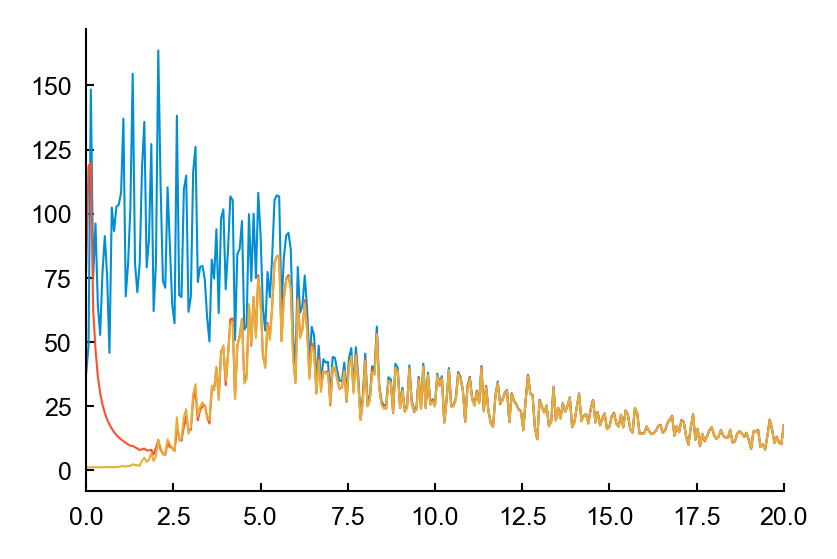

In [82]:
fft_max_w = np.abs(np.fft.rfft(lfp_max_w.T)).mean(axis=0)
fft_max_wf = np.abs(np.fft.rfft(lfp_max_wf.T)).mean(axis=0)
fft_max_wf2 = np.abs(np.fft.rfft(lfp_max_wf2.T)).mean(axis=0)
freqs = np.fft.rfftfreq(lfp_max_w.shape[0], dt)
plt.plot(freqs, fft_max_w)
plt.plot(freqs, fft_max_wf)
plt.plot(freqs, fft_max_wf2)
plt.xlim([0, 20])
plt.show()

In [84]:
n_delays = grid_search_results[session][area]['n_delays']
rank = grid_search_results[session][area]['rank']

In [91]:
delase_w = DeLASE(lfp_max_w, n_delays=n_delays, rank=rank, dt=dt, max_freq=300, max_unstable_freq=300, device='cuda')
delase_wf = DeLASE(lfp_max_wf, n_delays=n_delays, rank=rank, dt=dt, max_freq=300, max_unstable_freq=300, device='cuda')
delase_wf2 = DeLASE(lfp_max_wf2, n_delays=n_delays, rank=rank, dt=dt, max_freq=300, max_unstable_freq=300, device='cuda')
delase_w.fit()
delase_wf.fit()
delase_wf2.fit()

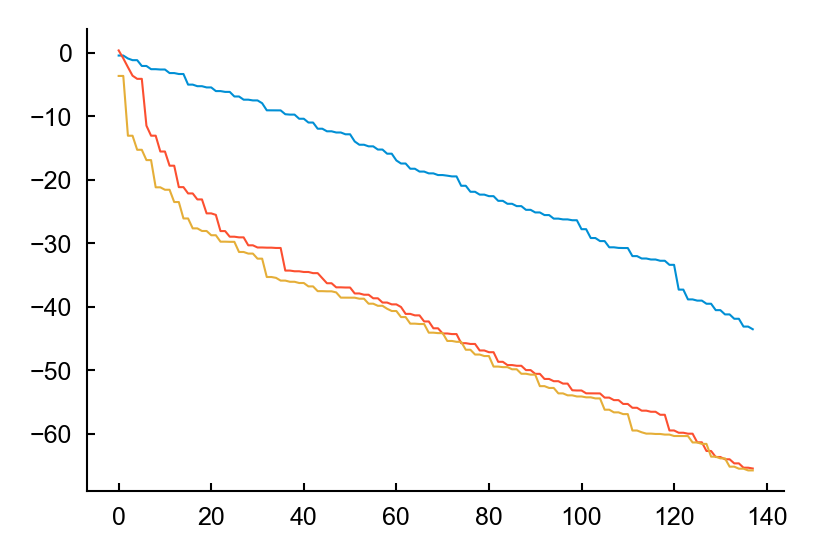

In [94]:
plt.plot(delase_w.stability_params[:int(top_percent*len(delase_w.stability_params))].cpu().numpy())
plt.plot(delase_wf.stability_params[:int(top_percent*len(delase_w.stability_params))].cpu().numpy())
plt.plot(delase_wf2.stability_params[:int(top_percent*len(delase_w.stability_params))].cpu().numpy())
plt.show()

# Look at data

In [33]:
monkey = 'Pedri'
dose = 'high'

In [35]:
for session_ind, session in enumerate(session_lists[monkey][dose]):
    leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
    post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
    # time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
    
    if session_ind == 4:
        break

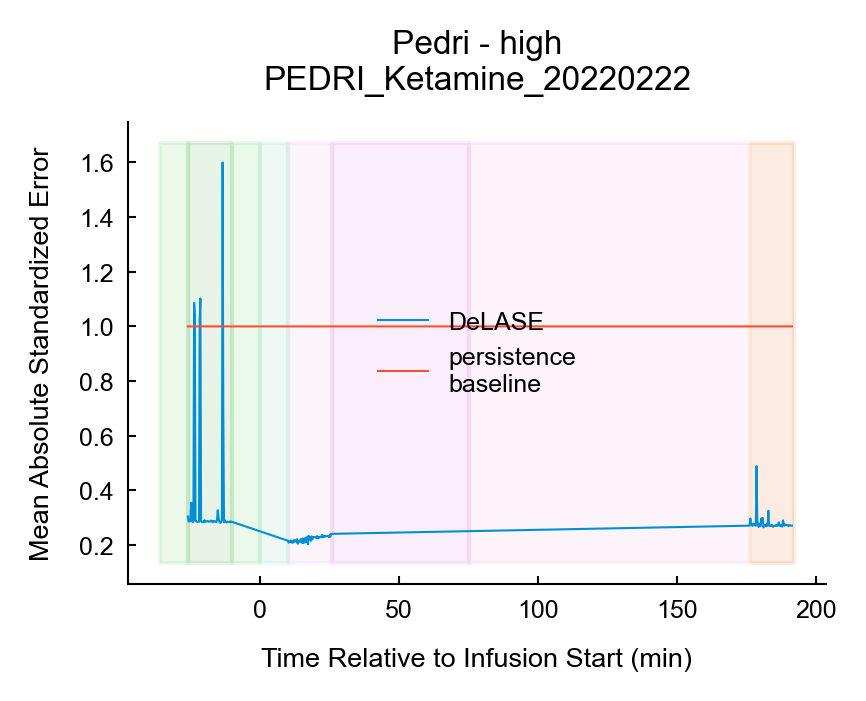

In [36]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
for area in areas:
# for area in ['vlPFC']:
    plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val, label='DeLASE')
    plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val_pb, label='persistence\nbaseline')
    # plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val_VAR)
ylim= plt.ylim()
for i, (section_name, section_bounds) in enumerate(section_info):
    plt.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)

plt.ylabel('Mean Absolute Standardized Error')
plt.xlabel('Time Relative to Infusion Start (min)')
plt.title(f"{monkey} - {dose}\n{session}")
# plt.plot(delase_results[session][area].mase_val_VAR_small)
plt.legend()
plt.show()

In [37]:
directory_path = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, session + '_lfp_chunked_20s', 'directory')
directory = pd.read_pickle(directory_path)

In [38]:
# row_ind = delase_results[session][area].mase_val.to_numpy().argmax()
row_ind = np.argsort(delase_results[session][area].mase_val.to_numpy())[-1]
# row_ind = 8
row_max_mase = delase_results[session][area].iloc[row_ind]

In [39]:
# lfp = load_window_from_chunks(row_max_mase.window_start, row_max_mase.window_end, directory)
# lfp_test = load_window_from_chunks(row_max_mase.test_window_start, row_max_mase.test_window_end, directory)
lfp_both = load_window_from_chunks(row_max_mase.window_start, row_max_mase.test_window_end, directory)

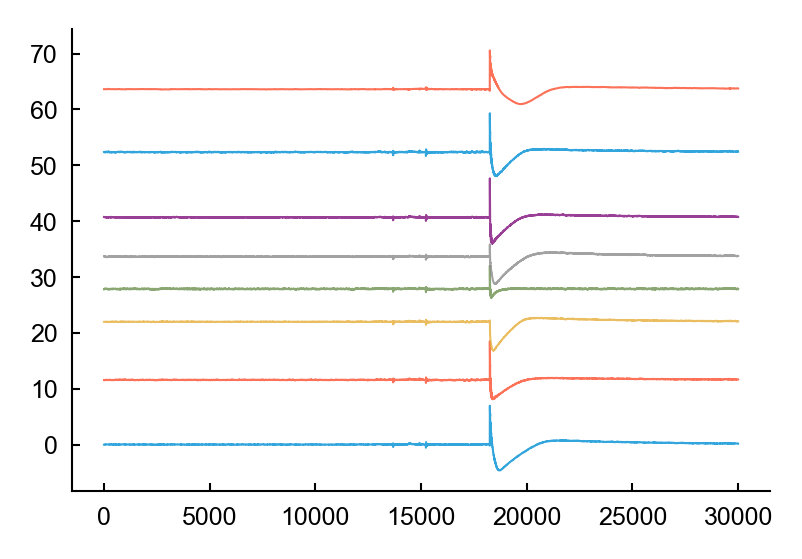

In [40]:
offset = 0
for i in range(0, lfp_both.shape[1], 16):
    plt.plot(lfp_both[:, i] + offset, alpha=0.8)
    offset += (lfp_both[:, i][lfp_both[:, i] > 0].max() + np.abs(lfp_both[:, i][lfp_both[:, i] < 0].min()))
# plt.plot(lfp[:, 0])

In [41]:
corr_mat = np.corrcoef(lfp_both.T)

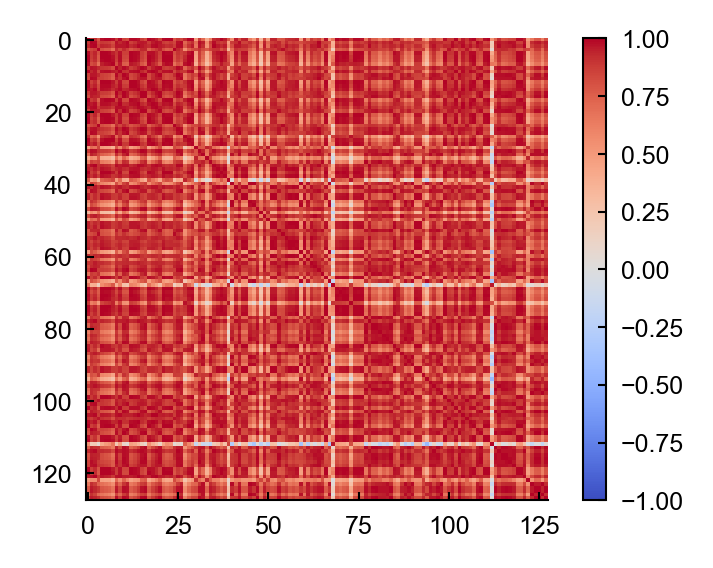

In [42]:
norm = Normalize(vmin=-1, vmax=1)
plt.imshow(corr_mat, norm=norm, cmap='coolwarm')
plt.colorbar()
plt.show()

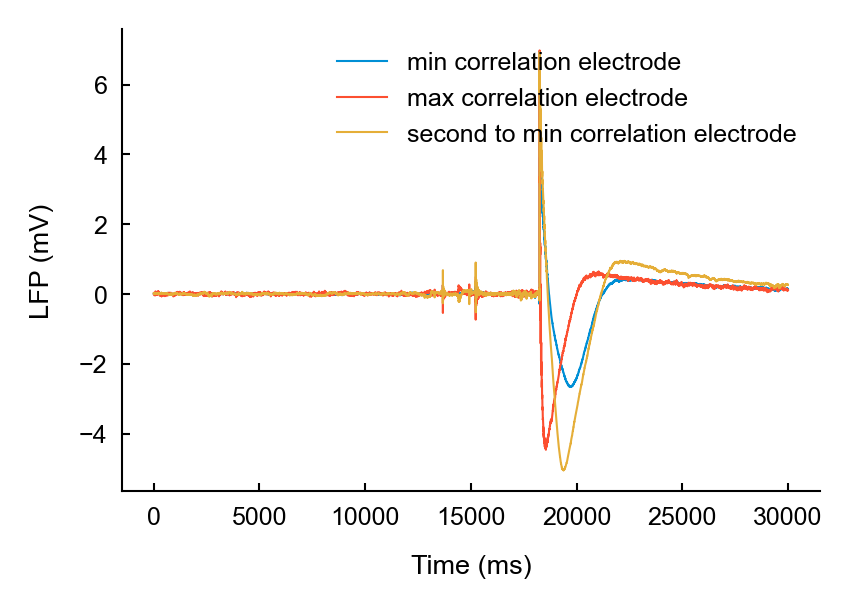

In [43]:
min_corr_ind = corr_mat.mean(axis=1).argmin()
second_to_min_corr_ind = np.argsort(corr_mat.mean(axis=1))[1]
max_corr_ind = corr_mat.mean(axis=1).argmax()

plt.plot(lfp_both[:, min_corr_ind], label='min correlation electrode')
plt.plot(lfp_both[:, max_corr_ind], label='max correlation electrode')
plt.plot(lfp_both[:, second_to_min_corr_ind], label='second to min correlation electrode')
plt.xlabel('Time (ms)')
plt.ylabel('LFP (mV)')
plt.legend()
plt.show()

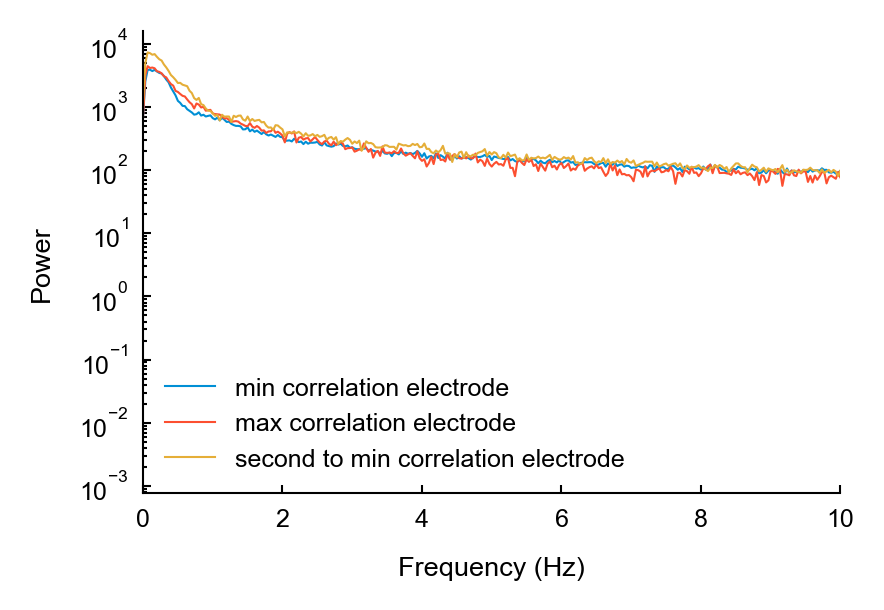

In [44]:
fft_vals = np.fft.rfft(lfp_both, axis=0)
fft_freq = np.fft.rfftfreq(lfp_both.shape[0], d=dt)

plt.plot(fft_freq, np.abs(fft_vals[:, min_corr_ind]), label='min correlation electrode')
plt.plot(fft_freq, np.abs(fft_vals[:, max_corr_ind]), label='max correlation electrode')
plt.plot(fft_freq, np.abs(fft_vals[:, second_to_min_corr_ind]), label='second to min correlation electrode')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.yscale('log')
plt.xlim([0, 10])
plt.legend()
plt.show()

In [62]:
variables = ['electrodeInfo']
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
electrode_info = session_vars['electrodeInfo']

In [63]:
lfp_all = load_window_from_chunks(0, T*dt, directory)
avg_std_dev = lfp_all.std(axis=0).mean()

In [64]:
std_dev_mult = 5
bad_electrodes = []
worst_electrode_example = []
window = 15
window_starts = np.arange(0, T*dt - window, window)
for window_start in tqdm(window_starts):
    window_end = window_start + window
    lfp_vals = load_window_from_chunks(window_start, window_end, directory)
    bad_electrodes.append(np.sum(np.abs(lfp_vals).max(axis=0) > avg_std_dev*std_dev_mult))
    worst_electrode_example.append(lfp_vals[:, np.argmax(lfp_vals.max(axis=0))])

  0%|          | 0/913 [00:00<?, ?it/s]

In [78]:
# bad_electrodes = []
# worst_electrode_example = []
# for row in tqdm(delase_results[session][area].itertuples(), total=len(delase_results[session][area])):
#     lfp_vals = load_window_from_chunks(row.window_start, row.test_window_end, directory)
#     bad_electrodes.append(np.sum(lfp_vals.max(axis=0) > avg_std_dev*5))
#     worst_electrode_example.append(lfp_vals[:, np.argmax(lfp_vals.max(axis=0))])

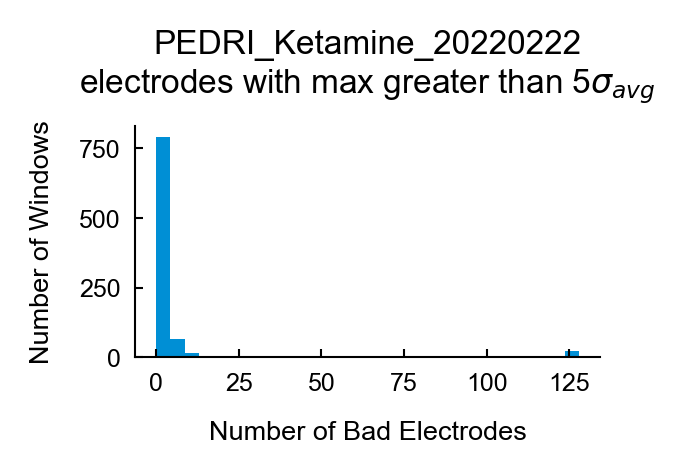

In [65]:
plt.figure(figsize=(2, 1))
plt.hist(bad_electrodes, bins=30)
plt.xlabel('Number of Bad Electrodes')
plt.ylabel('Number of Windows')
plt.title(f"{session}\nelectrodes with max greater than {std_dev_mult}" + r"$\sigma_{avg}$")
plt.show()

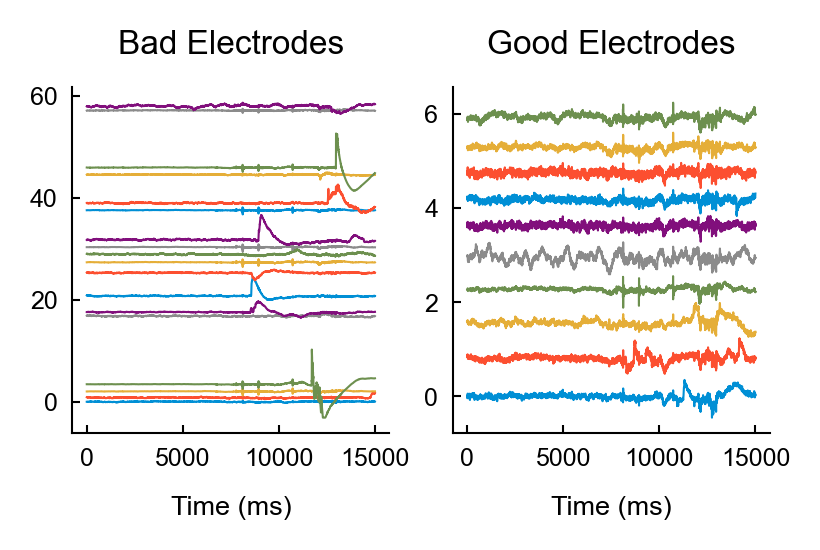

In [71]:
bad_electrode_indices = [i for i, num_bad in enumerate(bad_electrodes) if num_bad > 0 ]

# bad_elec_ind = 0
# window_ind = bad_electrode_indices[bad_elec_ind]

window_ind = int(np.argmax(np.array(bad_electrodes) > 2))


lfp_vals = load_window_from_chunks(window_starts[window_ind], window_starts[window_ind] + window, directory)
max_vals = np.abs(lfp_vals).max(axis=0)
sorted_inds = np.argsort(max_vals)
bad_boolean = max_vals > std_dev_mult*avg_std_dev
plt.figure(figsize=(3, 1.5))
plt.subplot(1, 2, 1)
offset = 0
for i in np.where(bad_boolean)[0]:
    plt.plot(lfp_vals[:, i] + offset)
    offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Bad Electrodes')
plt.xlabel('Time (ms)')
plt.subplot(1, 2, 2)
offset = 0
for i in sorted_inds[:-np.sum(bad_boolean)][::-1][:10]:
    plt.plot(lfp_vals[:, i] + offset)
    offset += (lfp_vals[:, i][lfp_vals[:, i] > 0].max() + np.abs(lfp_vals[:, i][lfp_vals[:, i] < 0].min()))
plt.title('Good Electrodes')
plt.xlabel('Time (ms)')
plt.show()

# Reanalyze?

In [71]:
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables=['electrodeInfo'], data_class=cfg.params.data_class, verbose=False)

In [72]:
electrode_info = session_vars['electrodeInfo']

In [73]:
awake_oddball_times = section_info[1][1]
unconscious_oddball_times = section_info[4][1]

In [597]:
len(np.where(['vlPFC' in area for area in electrode_info['area']])[0])

64

In [83]:
np.random.seed(43)
t_a = np.random.uniform(awake_oddball_times[0], awake_oddball_times[1])*60 + session_infos[session]['infusionStart']
t_u = np.random.uniform(unconscious_oddball_times[0], unconscious_oddball_times[1])*60 + session_infos[session]['infusionStart']
# lfp_a = load_window_from_chunks(t_a, t_a + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])
# lfp_u = load_window_from_chunks(t_u, t_u + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])

window = 30

lfp_a = load_window_from_chunks(t_a, t_a + window, directory)
lfp_u = load_window_from_chunks(t_u, t_u + window, directory)

In [88]:
# n_delays, rank = grid_search_results[session][area]['n_delays'], grid_search_results[session][area]['rank']
n_delays, rank = 10, 850

In [89]:
delase_a = DeLASE(lfp_a, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_a.fit()
delase_u = DeLASE(lfp_u, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_u.fit()

In [90]:
top_percent = 0.1

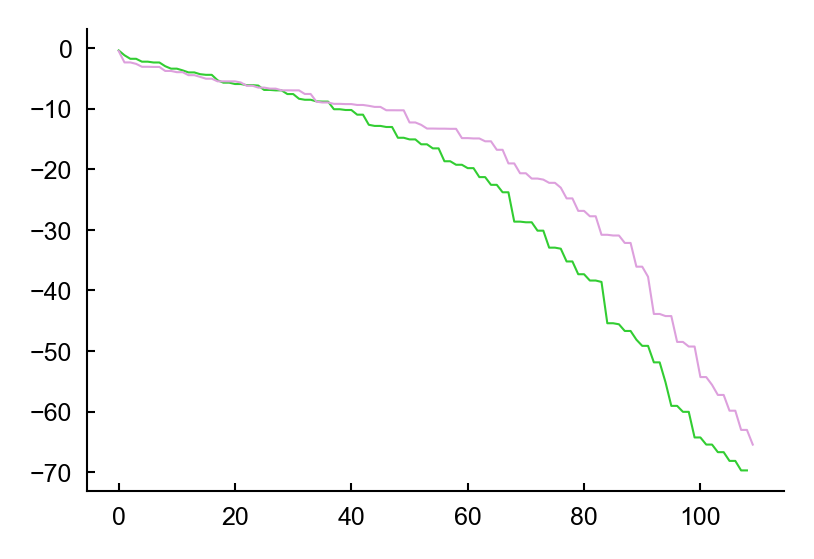

In [91]:
plt.plot(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), c='limegreen')
plt.plot(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), c='plum')

In [609]:
# plt.scatter(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), delase_a.stability_freqs[:int(top_percent*len(delase_a.stability_freqs))].cpu(), s=4, c='limegreen')
# plt.scatter(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), delase_u.stability_freqs[:int(top_percent*len(delase_u.stability_freqs))].cpu(), s=4, c='plum')
# # plt.scatter(stab_param2[:int(top_percent*len(stab_param1))], stab_freq2[:int(top_percent*len(stab_param1))], s=4)

In [610]:
delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu().mean(), delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu().mean()

(tensor(-19.5074), tensor(-19.9633))

In [611]:
mannwhitneyu(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), alternative='less')

MannwhitneyuResult(statistic=np.float64(3266.0), pvalue=np.float64(0.6941822488196869))

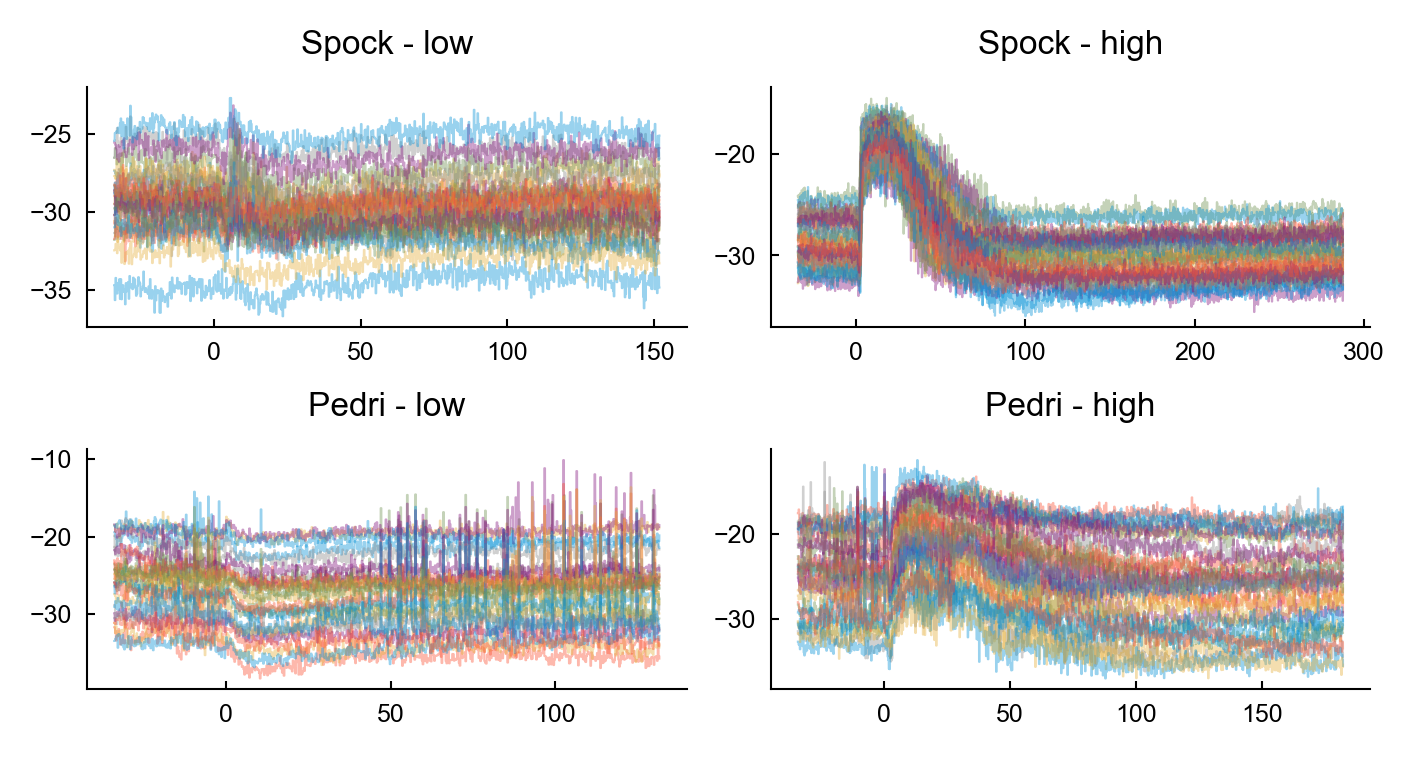

In [38]:
# leadup_time = 18 # minutes before anesthesia
# post_time = 25 # minutes after anesthesia

fig, axs = plt.subplots(2, 2, figsize=(4.7, 2.5045))

lns = []

for i, monkey in enumerate(session_lists.keys()):
    for j, dose in enumerate(session_lists[monkey].keys()):
        ax = axs[i][j]
        for area in stability_all[monkey][dose].keys():

            leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60

            time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
            plot_start_time = -leadup_time + 2
            plot_end_time = post_time - 10
            time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

            for session_ind in range(stability_all[monkey][dose][area].shape[-1]):
                ax.plot(time_vals[time_inds], stability_all[monkey][dose][area][time_inds, session_ind], label=area_labels[area], rasterized=True, alpha=0.4)

            ax.set_title(f"{monkey} - {dose}")

plt.tight_layout()
plt.show()

In [120]:
for monkey in session_lists.keys():
    for dose in session_lists[monkey].keys():
        print("-"*10)
        print(f"{monkey} - {dose}")
        for session in session_lists[monkey][dose]:
            print((grid_search_results[session][area]['n_delays'], grid_search_results[session][area]['rank']))

----------
Spock - low
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
----------
Spock - high
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
----------
Pedri - low
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
----------
Pedri - high
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)


In [37]:
variables = ['sessionInfo']
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
session_info = session_vars['sessionInfo']
if 'propofol' in cfg.params.data_class:
    drug_start = session_info['drugStart'][0]
elif 'lever' in cfg.params.data_class:
    drug_start = session_info['infusionStart']

In [38]:
for area in areas:
    break

In [39]:
results_df = delase_results[session][area]

In [40]:
top_percent = 0.1

In [41]:
mean_stab = results_df.stability_params.apply(lambda x: x[:int(len(x)*top_percent)].mean())

In [42]:
time_vals = results_df.window_start/60 - drug_start/60

In [43]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

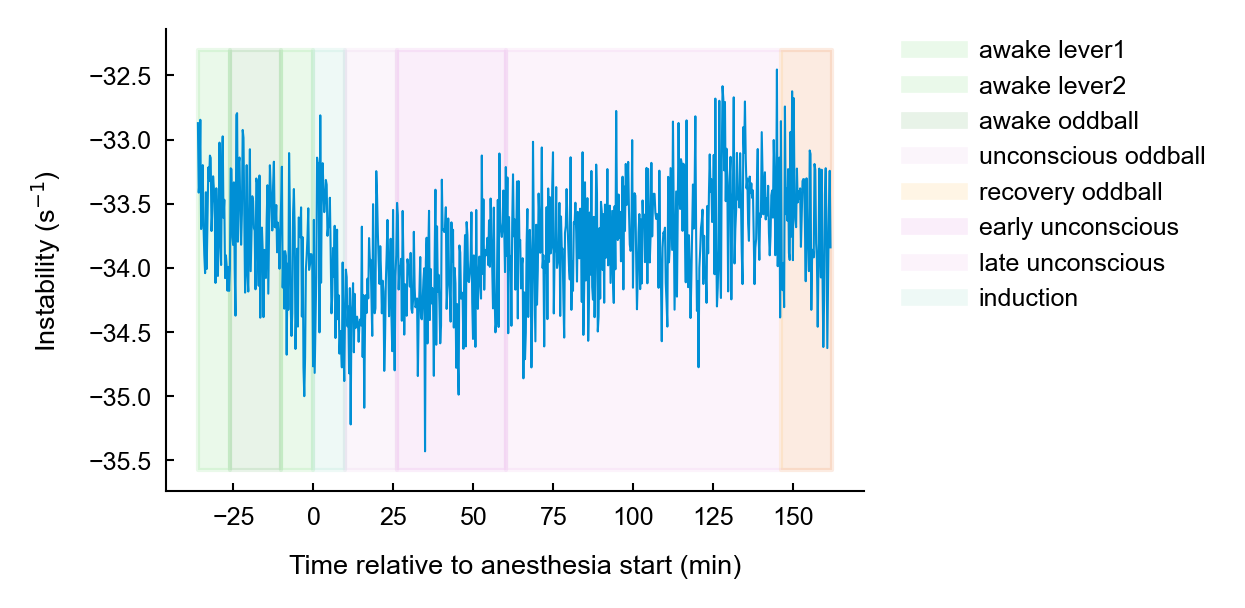

In [44]:
plt.plot(time_vals, mean_stab)
ylim = plt.ylim()

# def adjust_text_positions(section_info, ylim):
#     text_y_pos = []
#     for i, (_, section_bounds) in enumerate(section_info):
#         if i == 0:
#             y_pos = ylim[-1] + (ylim[-1] - ylim[0]) * 0.05
#         else:
#             y_pos = text_y_pos[-1] + (ylim[-1] - ylim[0]) * 0.1
#         text_y_pos.append(y_pos)
#     return text_y_pos

# text_y_pos = adjust_text_positions(section_info, ylim)

# # text_y_pos = np.linspace(ylim[-1] + (ylim[-1] - ylim[0])*0.05, ylim[-1] + (ylim[-1] - ylim[0])*0.2, len(section_info))
for i, (section_name, section_bounds) in enumerate(section_info):
    plt.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)
#     # plt.text(np.mean(section_bounds), ylim[-1] + (ylim[-1] - ylim[0])*0.05, '\n'.join(section_name.split(' ')), color=section_colors[section_name], ha='center', va='center')
#     plt.text(np.mean(section_bounds), text_y_pos[i], '\n'.join(section_name.split(' ')), color=section_colors[section_name], ha='center', va='center')
# plt.xlim([time_vals[0], 180])
plt.xlabel('Time relative to anesthesia start (min)')
plt.ylabel('Instability (s$^{-1}$)')

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4, alpha=0.1) for color in section_colors.values()]
plt.legend(legend_handles, section_colors.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.show()